# Рекуррентные сети пишут тексты
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW06] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит познакомиться с объединением Deep Learning и NLP. Для начала предстоит построить векторное пространство для словоря, а затем применить его для предсказания следующих слов в тексте.

In [1]:
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import json
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.neighbors import KDTree
import time
from collections import defaultdict
from torch.autograd import Variable
import itertools

In [2]:
tokenized = json.load(open("opencorp.json", "r", encoding="UTF-8"))

### Задание 1 (3 балла)
Чтобы обучить нейронную сеть, нам нужен датасет. В данном задании предлагается использовать данные, полученные из корпуса текстов OpenCorpora. Более того, датасет нужно представить в удобном виде. Поскольку мы хотим обучать эмбеддинги на парах `(token_center, token_context)`, а также иметь возможность делать `negative sampling`, датасет должен уметь выдавать соответствующие пары, а так же `negative sampling`-токены. 

Кроме того, мы бы не хотели строить эмбеддинги для очень редких слов, поэтому в словарь и в пары должны входить только слова, которые встречаются более `count_threshold` раз, а остальные должны быть заменены на специальный токен `"<UNKNOWN>"`. Последовательность должна начинаться с токена `"<START>"` и заканчиваться токеном `"<END>"`.

#### Методы
`__init__` - принимает на вход список последовтельностей токенов, преобразуя в соответствии с описанными выше критериями. При инициализации списка токенов нужно учитывать, что с вероятностью $1 - (\sqrt{\frac{0.001}{f(t)}} + 1) \cdot \frac{f(t)}{0.001}$ ($f(t)$ - частота слова в корпусе) мы "выкидываем" слово из текста, не добавляя никакие пары токенов с его участием в список. Это нужно для того, чтобы мы не переобучались на часто встречаемые слова. Также в `self.voc` должен записать актуальный словарь токенов.

`__len__` - возвращает количество пар `(token_center, token_context)`

`__getitem__` - принимает на вход индекс `i`, соответствующий паре `(t_i, c_i)`. Возвращает пару тензоров `(t_i, [c_i] + negatives)`, где `negatives` - список негативных токенов.

`negative_sampling` - осуществляет взвешенное негативное сэмплирование. Вес токена определяется как $\frac{(count(t))^{0.75}}{\sum (count(t))^{0.75}}$, т.е. в negative samples частые слова попадают чаще, чем другие.

In [7]:
class TokenDataset(Dataset):
    def __init__(self, tokenized_sources, window=3, count_threshold=5, negative_sampling=5):
        self.token_pairs = []
        self.neg_samp = negative_sampling
        self.counts = {"<START>": len(tokenized_sources), "<END>": len(tokenized_sources), "<UNKNOWN>":0}
        
        total_words_count = 2 * len(tokenized_sources)
        for sent in tokenized_sources:
            total_words_count += len(sent)
            for word in sent:
                if word in self.counts:
                    self.counts[word] += 1
                else:
                    self.counts[word] = 1
        
        rem_words = []
        for word in self.counts:
            if self.counts[word] < count_threshold:
                if word not in ["<UNKNOWN>", "<START>", "<END>"]:
                    self.counts["<UNKNOWN>"] += self.counts[word]
                    rem_words.append(word)
        [self.counts.pop(word) for word in rem_words]

        to_rem = copy.deepcopy(tokenized_sources)
        for sent in to_rem:
            for i  in range(len(sent)):
                if sent[i] in self.counts:
                    word = sent[i]
                else:
                    word = "<UNKNOWN>"
                    sent[i] = "<UNKNOWN>"

                if word not in ["<START>", "<END>"]:
                    f = self.counts[word] / total_words_count * 1000
                    f = 1 / f
                    if np.random.rand() < 1 - np.sqrt(f) - f:
                        sent[i] = "<DELETED>"
        
        for sent in to_rem:
            ns = ["<START>"] + sent + ["<END>"]
            for i, word in enumerate(ns):
                if word in self.counts:
                    word_to_add = word

                    if word == "<DELETED>":
                        continue

                    if word not in self.counts:
                        word_to_add = "<UNKNOWN>"

                    for j in range(-window, window+1):
                        pos = i + j
                        if pos >= 0 and pos < len(ns) and pos != i and ns[pos] != "<DELETED>":
                            self.token_pairs.append((word_to_add, ns[pos]))

        self.voc = np.array(list(self.counts.keys()))
        self.token2id = dict([(token, i) for i, token in enumerate(self.voc)])
        self.lc = len(self.voc)
        den = 0
        for word in self.counts:
            den += pow(self.counts[word], 0.75)

        self.prob = [pow(self.counts[word], 0.75) / den for word in self.voc]
        self.negs = None
                    
    def negative_sampling(self):
        self.negs = np.random.choice(np.arange(self.lc), p=self.prob, size=len(self.token_pairs) * self.neg_samp)
        
    def __getitem__(self, index):
        ns = list(self.negs[index * self.neg_samp: (index + 1) * self.neg_samp])
        t, c = self.token_pairs[index]

        t = self.token2id[t]
        c = self.token2id[c]
        

        return torch.tensor([t]), torch.tensor([c] + ns, dtype=torch.long)

    def __len__(self):
        return len(self.token_pairs)



### Задание 2 (4 балла)
Теперь реализуем непосредственно SkipGram. Для этого нам потребуются `torch.autograd.Variables` чтобы сделать эмбеддинги обучаемыми. Также сразу реализуем интерфейс, которым будем пользоваться для применения эмбеддингов в следующих задачах.

#### Методы SkipGram
`__init__` - принимает на вход словарь и размерность пространств эмбеддингов. Инициализирует эмбеддинги для центрального и контекстного слов.

`get_variables` - возвращает лист из всех `torch.autograd.Variables`. Необходимо, чтобы инициализировать оптимизатор.

`predict_proba(center_tokens, context_tokens)` - принимает на вход список центральных токенов и список списков токенов из предполагаемого контекста. Для каждого центрального токена и соответствующего ему списка контекстных токенов должен вернуть скалярное произведение центрального и контекстуального эмбеддингов.

#### Методы Embedding
`__init__` - принимает на вход обученный SkipGram

`embed` - возвращает эмбеддинги для всех элементов списка

`reconstruct` - для всех элементов списка возвращает наиболее подходящий токен. Не возвращает `"<UNKNOWN>"`

`n_closest` - возвращает `n` ближайших токенов для каждого элемента списка. Не возвращает `"<UNKNOWN>"`

In [11]:
class SkipGram:
    def __init__(self, voc, latent_size):
        self.id2token = list(voc)
        self.token2id = dict([(token, i) for i, token in enumerate(self.id2token)])
        self.v = Variable(torch.randn(len(voc) ,latent_size).float().cuda(), requires_grad=True)
        self.u = Variable(torch.randn(latent_size, len(voc)).float().cuda(), requires_grad=True)
        self.ls = latent_size
        
    def get_variables(self):
        return [self.v, self.u]
    
    def predict_proba(self, center_ids, context_ids):
        bs = context_ids.shape[0]
        ns = context_ids.shape[1]  
        ls = self.ls
        res = torch.bmm(self.v[center_ids], self.u[:,context_ids].transpose(1, 0))
        return res.reshape(bs, ns).cuda()
            
class Embedding:
    def __init__(self, skip_gram):
        self.skip_gram = skip_gram
        self.tree = KDTree(skip_gram.v.cpu().detach().numpy())
    
    def embed(self, tokens):
        res = torch.zeros(len(tokens) , self.skip_gram.ls)
        for i, token in enumerate(tokens):
            if token in self.skip_gram.token2id:
                res[i] = self.skip_gram.v[self.skip_gram.token2id[token]]
            else:
                res[i] = self.skip_gram.v[self.skip_gram.token2id["<UNKNOWN>"]]
        return res.detach().numpy()
    
    def reconstruct(self, embeddings):
        _, inds = self.tree.query(embeddings, 2)
        res = []
        for ind in inds:
            if not self.skip_gram.id2token[ind[0]] == "<UNKNOWN>":
                res.append(self.skip_gram.id2token[ind[0]])
            else:
                res.append(self.skip_gram.id2token[ind[1]])
        return res

    def n_closest(self, embeddings, n=5):
        res = [[] for _ in range(len(embeddings))]
        _, inds = self.tree.query(embeddings, k=n+1)
        for i, _ in enumerate(embeddings):
            for ind in inds[i]:
                if self.skip_gram.id2token[ind] != "<UNKNOWN>" and len(res[i]) < n:
                    res[i].append(self.skip_gram.id2token[ind])
        return res

Creating dataset...
Creating skipgram...



Loss: 12.050747838151564



Loss: 8.063266235316565



Loss: 5.931427630736558



Loss: 4.657376541347679



Loss: 3.792607227523757



Loss: 3.182452046688908



Loss: 2.745180854593213



Loss: 2.4233723348798373



Loss: 2.1811190032084053



Loss: 1.9931710769641655



Loss: 1.8472810590668192



Loss: 1.7314252705384467



Loss: 1.6387910820293135



Loss: 1.563520738181718



Loss: 1.5027847947695203



Loss: 1.4527452650420163



Loss: 1.411642998511638



Loss: 1.3761672970716377



Loss: 1.3467484092858224



Loss: 1.3211840283980063



Loss: 1.2992298366097499



Loss: 1.280022778569376



Loss: 1.2626289740979488



Loss: 1.2477512306394198



Loss: 1.2342130782771912



Loss: 1.2217480769580293



Loss: 1.2104018099811098



Loss: 1.2002022422417225



Loss: 1.1908886994061485



Loss: 1.1816753660137864



Loss: 1.1735387581933165



Loss: 1.165908413706205



Loss: 1.1582858549345525



Loss: 1.1515497705622915



Loss: 1.1454417862294282



Loss: 1.1389848887738103



Loss: 1.1334499043426747



Loss: 1.1281567339503438



Loss: 1.1230543915284883



Loss: 1.1177819394919486



Loss: 1.113254427472386



Loss: 1.108912200811077



Loss: 1.104804736029482



Loss: 1.100481567178662



Loss: 1.0967273943285694



Loss: 1.093070913017343



Loss: 1.0894718580654272



Loss: 1.085904076704556



Loss: 1.0827296127966786



Loss: 1.0796181774285225



Loss: 1.0766952125304337



Loss: 1.073976535461729



Loss: 1.0713292610390106



Loss: 1.068726040318107



Loss: 1.0656860775174715



Loss: 1.0639808120348402



Loss: 1.060901243679385



Loss: 1.0585568740462674



Loss: 1.0566200030323927



Loss: 1.0537781087630385



Loss: 1.0525397683502338



Loss: 1.0501730384447523



Loss: 1.048343022919576



Loss: 1.0464827392808524



Loss: 1.0449635930382148



Loss: 1.0428218660369197



Loss: 1.041553953262644



Loss: 1.0394703878539782



Loss: 1.0384599726499038



Loss: 1.0367443899495885



Loss: 1.0347471254316674



Loss: 1.033492345109992



Loss: 1.0318211754163107



Loss: 1.0302342470997334



Loss: 1.029300261272932



Loss: 1.0276155989104454



Loss: 1.0268036694701659



Loss: 1.0256825008888129



Loss: 1.0245371212653065



Loss: 1.0228477085402252



Loss: 1.0219470421108632



Loss: 1.0212173754651248



Loss: 1.0193896305670431



Loss: 1.0189547351011807



Loss: 1.0179822001253065



Loss: 1.0168185528994336



Loss: 1.0153740867926804



Loss: 1.014436271649982



Loss: 1.0141577700956153



Loss: 1.0130575130474313



Loss: 1.0123138445597542



Loss: 1.01131719365397



Loss: 1.0103600669709185



Loss: 1.0089909724868402



Loss: 1.0092172532271173



Loss: 1.0078489968536097



Loss: 1.006928158681327



Loss: 1.0065297597774308



Loss: 1.0053688721919278



Loss: 1.0050529259425056



Loss: 1.0042982117116268



Loss: 1.0036534646600028



Loss: 1.0024337250887436



Loss: 1.0021270054560554



Loss: 1.001862496520401



Loss: 1.001145412068848



Loss: 1.0006146275669063



Loss: 0.9997353780889365



Loss: 0.9988800793977324



Loss: 0.9980998432599806



Loss: 0.99796918590499



Loss: 0.9974935588851253



Loss: 0.996497679595189



Loss: 0.995885458342526



Loss: 0.995600633883695



Loss: 0.9952349405405354



Loss: 0.9945119997776977



Loss: 0.9939016115045693



Loss: 0.993695256834001



Loss: 0.9930455361302111



Loss: 0.9924832237969845



Loss: 0.9919450628648111



Loss: 0.9916911138307064



Loss: 0.9911055261571108



Loss: 0.9912175737025176



Loss: 0.9902235799973164



Loss: 0.9900044381436223



Loss: 0.989688972777912



Loss: 0.9893037160602185



Loss: 0.988192597514628



Loss: 0.9880489544401839



Loss: 0.9877762834595614



Loss: 0.9874251393003202



Loss: 0.9876459383089607



Loss: 0.9865712318945369



Loss: 0.9860053957420023



Loss: 0.9860120894712046



Loss: 0.9855656366464924



Loss: 0.9852224518764274



Loss: 0.9847120753851141



Loss: 0.984549330753653



Loss: 0.984693023516862



Loss: 0.9838323916134849



Loss: 0.983757524789291



Loss: 0.98307086407956



Loss: 0.982828158632331



Loss: 0.9826881638360679



Loss: 0.9824517787414224



Loss: 0.9818274584020679



Loss: 0.9817362371934664



Loss: 0.9812993111231276



Loss: 0.9812818531231778



Loss: 0.9807163263679645



Loss: 0.980416819152482



Loss: 0.9802097285194864



Loss: 0.9800877720937816



Loss: 0.9798531414536525



Loss: 0.9799001532227986



Loss: 0.9789261772362828



Loss: 0.97880998040558



Loss: 0.9787486752603397



Loss: 0.9787133434132333



Loss: 0.9780145562023198



Loss: 0.9778333750339823



Loss: 0.9777050847671812



Loss: 0.9777483251116691



Loss: 0.977039416886251



Loss: 0.9770445735082713



Loss: 0.9767259060425131



Loss: 0.976608057962645



Loss: 0.9763758339648582



Loss: 0.9761432622550824



Loss: 0.9761207043213217



Loss: 0.975354835564208



Loss: 0.9758989067981731



Loss: 0.9750570747830453



Loss: 0.9751333913671861



Loss: 0.9744876674191303



Loss: 0.9744172617929792



Loss: 0.9745667072975672



Loss: 0.9742924699360442



Loss: 0.97383089831116



Loss: 0.9738765317001109



Loss: 0.9732930035766112



Loss: 0.9734364882521673



Loss: 0.9731642999051179



Loss: 0.9726137891821905



Loss: 0.9730633451304305



Loss: 0.9728882300744363



Loss: 0.972649427364361



Loss: 0.9726029257161901



Loss: 0.9727122280211259



Loss: 0.9723278004459649



Loss: 0.9717147711949247



Loss: 0.9717906037601856



Loss: 0.9715559131508573



Loss: 0.9710731509628646



Loss: 0.9707627802449265



Loss: 0.9710523504729665



Loss: 0.9708830730995271


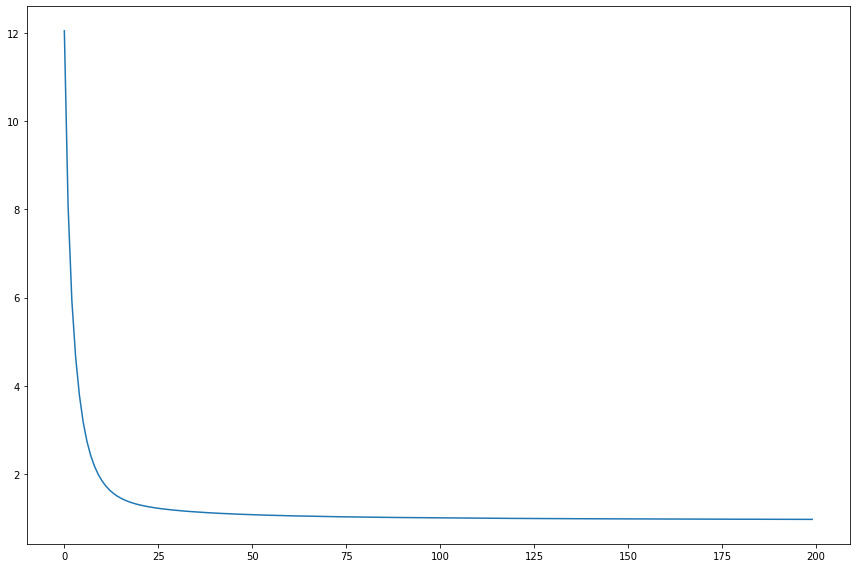

In [20]:
BATCH_SIZE = 4096
EPOCHS = 200

print("Creating dataset...")
dataset = TokenDataset(tokenized, count_threshold=10, window=4, negative_sampling=5)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Creating skipgram...")
skipgram = SkipGram(dataset.voc, 144)
optim = torch.optim.Adam(skipgram.get_variables(), lr=1e-3)
y = torch.tensor([0] * (BATCH_SIZE + 1), dtype=torch.long).cuda()
losses = []

for i in range(EPOCHS):
    avg_loss = 0
    steps = 0
    # ct = time.time()
    dataset.negative_sampling()
    for batch in tqdm(dataloader):
        probs = skipgram.predict_proba(batch[0], batch[1])
        loss = F.cross_entropy(probs, y[:len(probs)])
        optim.zero_grad()
        loss.backward()
        optim.step()
        avg_loss += loss.item()
        # print(time.time()-ct)
        # ct = time.time()
        steps += 1
    losses.append(avg_loss/steps)
    print("Loss:", avg_loss/steps)

plt.figure(figsize=(12, 8))
plt.plot(list(range(EPOCHS)), losses)
plt.tight_layout()
plt.show()

In [21]:
embedder = Embedding(skipgram)

In [24]:
king = embedder.embed(["король"])[0]
cat = embedder.embed(["кошка"])[0]
owl = embedder.embed(["сыч"])[0]
give = embedder.embed(["дать"])[0]
me = embedder.embed(["ты"])[0]
you = embedder.embed(["я"])[0]
print(embedder.n_closest([king], 10)[0])
print(embedder.n_closest([cat], 10)[0])
print(embedder.n_closest([owl], 10)[0])
print(embedder.n_closest([give], 10)[0])
print(embedder.n_closest([me], 10)[0])
print(embedder.n_closest([you], 10)[0])

['король', 'он', 'в', 'после', 'и', 'ибо', ',', '»', 'оно', 'её']
['кошка', 'думает', 'та', 'моего', 'сих', 'миру', 'снова', 'впрочем', 'последняя', 'ради']
['и', ',', '.', 'в', '(', ')', 'но', ':', '»', 'его']
['дать', 'ему', 'только', 'и', ',', 'им', 'возможность', ':', 'не', 'по']
['ты', 'я', '?', 'вот', 'ведь', '…', 'да', 'не', '—', 'он']
['я', 'он', 'но', ',', 'просто', 'не', 'мне', 'и', '.', 'меня']


In [25]:
putin = embedder.embed(["путин"])[0]
print(embedder.n_closest([putin], 10)[0])

['путин', 'владимир', 'президент', 'россии', 'в', 'он', 'рф', 'заявил', 'сегодня', 'на']


### Задание 3 (2 балла)
Теперь будем учиться восстанавливать слова в тексте. Для этого нам потребуется также определить датасет последовательностей фиксированной длинны.

#### Методы
`__init__` - принимает на вход `embedder` (обученный SkipGram) и список токенизированных последоватлеьностей `tokenized`.

`__getitem__` - возвращает случайную закодированную при помощи SkipGram подпоследовательность длины `seq_len` одной из исходных последовательностей, сдвинутую на один токен подпоследовательность (т.е. следующие слова в тексте) и маску, которая отражает то, является ли токен неизвестным (`"<UNKNOWN"`).

`__len__` - равна количеству последовательностей.

In [26]:
class TokenSeqDataset(Dataset):
    def __init__(self, embedder, tokenized, seq_len=32):
        self.seq_len = seq_len
        self.tokenized = tokenized
        self.embedder = embedder
            
    def __len__(self):
        return len(tokenized)

    def __getitem__(self, index):
        top = max(len(self.tokenized[index]) - self.seq_len, 0)
            
        ind = np.random.randint(0, 1 + top)
        
        sent = copy.deepcopy(self.tokenized[index])
        sent = sent + ["<END>"] * (1 + max(0, self.seq_len-len(sent)))
        seq = sent[ind: ind + self.seq_len + 1]
        mask = [token in self.embedder.skip_gram.token2id
                for token in seq[1:]]
        mask = torch.Tensor(np.array(mask))
        resseq = [self.embedder.embed([word])[0] for word in seq]
        resseq = torch.Tensor(np.array(resseq))
        a1 = copy.deepcopy(resseq[:-1])
        a2 = copy.deepcopy(resseq[1:])
        return a1, a2, mask

### Задание 4 (2 балла)
Теперь обучим рекуррентную сеть, которая будет предсказывать следующее слово в тексте. Модель будет состоять из трех блоков: `input` (отвечает за предоброботку эмбеддинга), `rnn` (рекуррентная часть), `output` (отвечает за постобработку выхода).

#### Методы
`predict_sequential` - возвращает последовательность предсказаний для батча последовательностей

`get_next` - предсказывает следующее слово

`reset` - обнуляет внутреннее состояние сети

In [35]:
class TextRNN:
    def __init__(self, latent_space=150, hidden_layer=512):
        self.input = torch.nn.Sequential(
            torch.nn.Linear(latent_space, hidden_layer),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer, hidden_layer),
            torch.nn.ReLU()
        )
        self.rnn = torch.nn.LSTM(hidden_layer, hidden_layer)
        self.output = torch.nn.Linear(hidden_layer, latent_space)
        self.input.cuda()
        self.rnn.cuda()
        self.output.cuda()
        self.hidden = None
    
    def predict_sequential(self, sequences):
        x, _ = self.rnn(self.input(sequences))
        return self.output(x)
    
    def parameters(self):
        return list(self.input.parameters()) + list(self.rnn.parameters()) + list(self.output.parameters())
    
    def get_next(self, batch):
        x, self.hidden = self.rnn(self.input(batch).unsqueeze(1))
        return self.output(x)
    
    def reset(self):
        self.hidden = None


Loss: 0.1370057922190804
Top-1 accuracy: 0.020833333333333332
Top-5 accuracy: 0.125



Loss: 0.1349784910208561
Top-1 accuracy: 0.035833333333333335
Top-5 accuracy: 0.15083333333333335



Loss: 0.13438353631831088
Top-1 accuracy: 0.030833333333333334
Top-5 accuracy: 0.11916666666666666



Loss: 0.13380355076041334
Top-1 accuracy: 0.020833333333333332
Top-5 accuracy: 0.1275



Loss: 0.1333626560446036
Top-1 accuracy: 0.02666666666666667
Top-5 accuracy: 0.11166666666666668



Loss: 0.13306225714988487
Top-1 accuracy: 0.023333333333333334
Top-5 accuracy: 0.09000000000000001



Loss: 0.13295576280830707
Top-1 accuracy: 0.018333333333333333
Top-5 accuracy: 0.105



Loss: 0.13268732222607763
Top-1 accuracy: 0.023333333333333334
Top-5 accuracy: 0.11916666666666668



Loss: 0.13236111825783783
Top-1 accuracy: 0.02416666666666667
Top-5 accuracy: 0.12



Loss: 0.13252382049726885
Top-1 accuracy: 0.021666666666666667
Top-5 accuracy: 0.10583333333333333



Loss: 0.13262780554023296
Top-1 accuracy: 0.0175
Top-5 accuracy: 0.1025



Loss: 0.13230472996187367
Top-1 accuracy: 0.012499999999999999
Top-5 accuracy: 0.09166666666666667



Loss: 0.13219842515217506
Top-1 accuracy: 0.022500000000000003
Top-5 accuracy: 0.12166666666666665



Loss: 0.13252363355205304
Top-1 accuracy: 0.020833333333333332
Top-5 accuracy: 0.1275



Loss: 0.1325181814349965
Top-1 accuracy: 0.029166666666666664
Top-5 accuracy: 0.11750000000000001



Loss: 0.13211445428703314
Top-1 accuracy: 0.03333333333333333
Top-5 accuracy: 0.1375



Loss: 0.1322308822946493
Top-1 accuracy: 0.03166666666666667
Top-5 accuracy: 0.13416666666666668



Loss: 0.13211312508860298
Top-1 accuracy: 0.023333333333333334
Top-5 accuracy: 0.10583333333333333



Loss: 0.1320768627910519
Top-1 accuracy: 0.0275
Top-5 accuracy: 0.12666666666666668



Loss: 0.13199382322373185
Top-1 accuracy: 0.025833333333333333
Top-5 accuracy: 0.10083333333333334



Loss: 0.13203864789682368
Top-1 accuracy: 0.028333333333333332
Top-5 accuracy: 0.14333333333333334



Loss: 0.1319720301764748
Top-1 accuracy: 0.030833333333333334
Top-5 accuracy: 0.12083333333333333



Loss: 0.13200628075538284
Top-1 accuracy: 0.03333333333333333
Top-5 accuracy: 0.13749999999999998



Loss: 0.1319194297086559
Top-1 accuracy: 0.02666666666666667
Top-5 accuracy: 0.12833333333333333



Loss: 0.13196987333240304
Top-1 accuracy: 0.024999999999999998
Top-5 accuracy: 0.09749999999999999



Loss: 0.13175762278891084
Top-1 accuracy: 0.0275
Top-5 accuracy: 0.11083333333333334



Loss: 0.13189577765490526
Top-1 accuracy: 0.024999999999999998
Top-5 accuracy: 0.11750000000000001



Loss: 0.13193741028639566
Top-1 accuracy: 0.032499999999999994
Top-5 accuracy: 0.14416666666666664



Loss: 0.13181427113736588
Top-1 accuracy: 0.022500000000000003
Top-5 accuracy: 0.12



Loss: 0.1319331065612378
Top-1 accuracy: 0.025833333333333333
Top-5 accuracy: 0.11916666666666666



Loss: 0.13161093523831066
Top-1 accuracy: 0.0275
Top-5 accuracy: 0.11666666666666668



Loss: 0.131816764903623
Top-1 accuracy: 0.034999999999999996
Top-5 accuracy: 0.13499999999999998



Loss: 0.13176968572444694
Top-1 accuracy: 0.014999999999999998
Top-5 accuracy: 0.09500000000000001



Loss: 0.1317495071511728
Top-1 accuracy: 0.023333333333333334
Top-5 accuracy: 0.12250000000000001



Loss: 0.1316384559750953
Top-1 accuracy: 0.02
Top-5 accuracy: 0.12666666666666668



Loss: 0.131741531799699
Top-1 accuracy: 0.01916666666666667
Top-5 accuracy: 0.10333333333333333



Loss: 0.13169889061702447
Top-1 accuracy: 0.030000000000000002
Top-5 accuracy: 0.125



Loss: 0.13185287623409417
Top-1 accuracy: 0.0275
Top-5 accuracy: 0.12583333333333332



Loss: 0.1315974103800482
Top-1 accuracy: 0.024999999999999998
Top-5 accuracy: 0.11916666666666668



Loss: 0.13179414158693184
Top-1 accuracy: 0.015
Top-5 accuracy: 0.09583333333333333


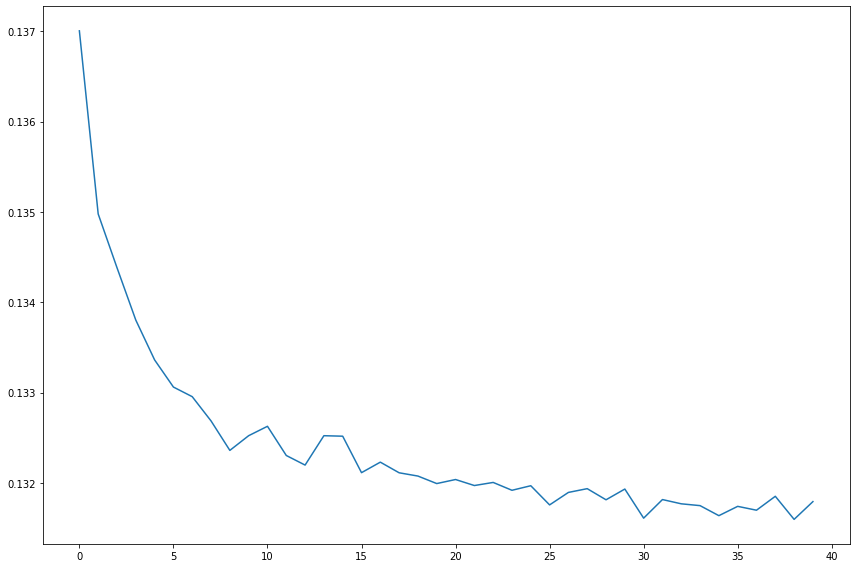

ValueError: x and y must have same first dimension, but have shapes (100,) and (40,)

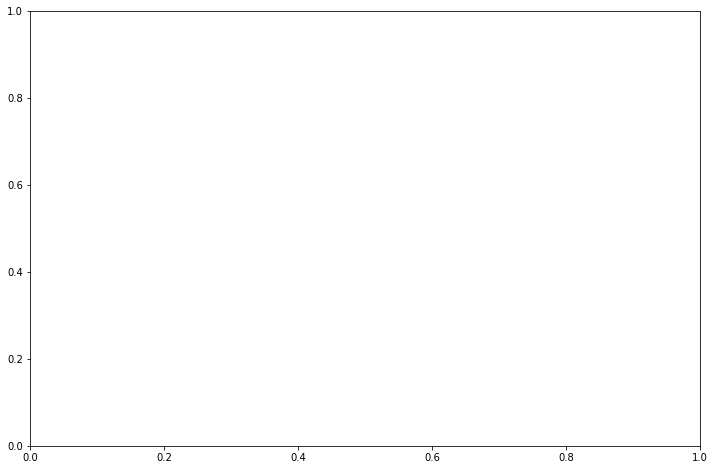

In [30]:
BATCH_SIZE = 64
EPOCHS = 40

dataset = TokenSeqDataset(embedder, tokenized)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
rnn = TextRNN(144)
optim = torch.optim.Adam(rnn.parameters(), lr=1e-3)
losses = []
top1accs = []
top5accs = []
for i in range(EPOCHS):
    avg_loss = 0
    top1acc = 0
    top5acc = 0
    steps = 0
    acc_steps = 0
    for x, y_true, loss_mask in tqdm(dataloader):
        y_pred = rnn.predict_sequential(x.cuda())
        loss = (((y_true.cuda() - y_pred)**2).mean(dim=-1) * loss_mask.cuda()).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        avg_loss += loss.item()
        steps += 1
        if steps % 100 == 0:
            acc_steps += 1
            word_pred = embedder.n_closest(y_pred.detach().view(-1, 144)[:200].cpu().numpy())
            word_true = embedder.reconstruct(y_true.detach().view(-1, 144)[:200].cpu().numpy())

            unknown_mask = loss_mask.view(-1).cpu().numpy()
            t1a = 0
            t5a = 0
            for true, pred, is_unknown in zip(word_true, word_pred, unknown_mask):
                if is_unknown:
                    continue
                if true == pred[0]:
                    t1a += 1
                if true in pred:
                    t5a += 1
            top1acc += t1a / len(word_pred)
            top5acc += t5a / len(word_pred)
    losses.append(avg_loss/steps)
    top1accs.append(top1acc/acc_steps)
    top5accs.append(top5acc/acc_steps)
    print("Loss:", avg_loss/steps)
    print("Top-1 accuracy:", top1acc/acc_steps)
    print("Top-5 accuracy:", top5acc/acc_steps)

plt.figure(figsize=(12, 8))
plt.plot(list(range(EPOCHS)), losses)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))
plt.plot(list(range(100)), top1accs, label="Top-1")
plt.plot(list(range(100)), top5accs, label="Top-5")
plt.legend()
plt.tight_layout()
plt.show()

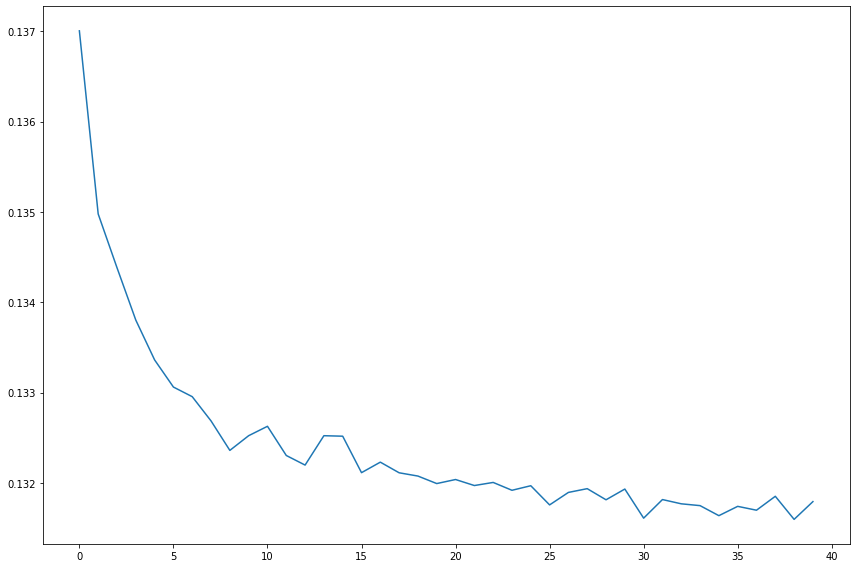

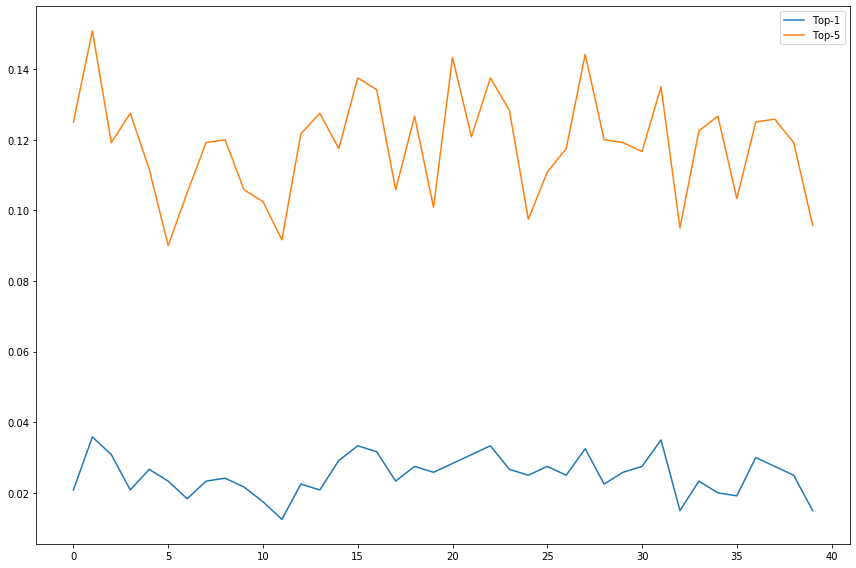

In [69]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(EPOCHS)), losses)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))
plt.plot(list(range(len(top1accs))), top1accs, label="Top-1")
plt.plot(list(range(len(top5accs))), top5accs, label="Top-5")
plt.legend()
plt.tight_layout()
plt.show()

### Задание 5 (1 балл)
Отлично, осталось только научитсья итеративно продолжать последовательность. Давайте попробуем научиться это делать.

#### Методы
`continue_sequence` - возвращает завершенную последовательность. Входная последовательность может быть пустой, поэтому в начало нужно добавить токен `"<START>"`. Закончить построение последовательности нужно после получения токена `"<END>"` или после получения `max_len` новых слов.

In [65]:
class SequenceCompleter:
    def __init__(self, rnn, embedder, max_len=128):
        self.rnn = rnn
        self.embedder = embedder
        self.max_len = max_len
        
    def continue_sequence(self, sequence):
        t_sequence = ["<START>"] + sequence
        embedding = self.embedder.embed(t_sequence)
        self.rnn.reset()
        with torch.no_grad():
            for e in embedding:
                x = get_next2(self.rnn, torch.tensor([e], dtype=torch.float).cuda())
            rec = self.embedder.reconstruct(x.cpu().reshape(1, 144))
            continued_sequence = []
            ctn = 0
            while rec[0] != "<END>" and ctn < self.max_len:
                ctn += 1
                continued_sequence.append(rec[0])
                e = self.embedder.embed(rec)
                x = get_next2(self.rnn, torch.tensor(e, dtype=torch.float).cuda())
                rec = self.embedder.reconstruct(x.cpu().reshape(1, 144))
        return sequence + continued_sequence

In [45]:
def get_next2(lst, batch):
    x, lst.hidden = lst.rnn(lst.input(batch).unsqueeze(1))
    return lst.output(x)

In [66]:
seq_completer = SequenceCompleter(rnn, embedder, 1)


In [68]:
seq_completer = SequenceCompleter(rnn, embedder)
print(seq_completer.continue_sequence(["учеба", "в", "магистратуре", "-", "это"]))
print(seq_completer.continue_sequence(["работает", "ли", "наша", "простая", "модель", "?"]))
print(seq_completer.continue_sequence(["я", "точно", "знаю"]))
print(seq_completer.continue_sequence(["машина", "времени"]))
print(seq_completer.continue_sequence(["сегодня"]))
print(seq_completer.continue_sequence([]))

['учеба', 'в', 'магистратуре', '-', 'это', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',']
['работает', 'ли', 'наша', 'простая', 'модель', '?']
['я', 'точно', 'знаю', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '

In [ ]:
class CharLSTM:
    def __init__(self, symbols):
        self.hidden = None
        self.input = torch.nn.Linear(len(symbols), 128)
        self.lstm = torch.nn.LSTM(128, 128)
        self.output = torch.nn.Sequential(torch.nn.Linear(128, 128), torch.nn.ReLU(), torch.nn.Linear(128, len(symbols)))
    
    def loss(self, batch):
        pass